In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [4]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Using the inspector to print the column names within the 'hawaii' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Using the inspector to print the column names within the 'hawaii' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Create our session (link) from Python to the DB
# Use `engine.execute` to select and display the first 10 rows from the measurement & station tables
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [8]:
# View all of the classes that automap found
base = automap_base()
base.prepare(engine, reflect=True)

In [9]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [10]:
# Create a Session Object to Connect to DB
session = Session(bind=engine)

In [11]:
# Get the most recent date
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# recent_date

# Date 12 months from the latest date
prev_twelve = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
# prev_twelve

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
#------------------

m_results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date >= prev_twelve).\
    group_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(m_results, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df.head(10)

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


<function matplotlib.pyplot.show(close=None, block=None)>

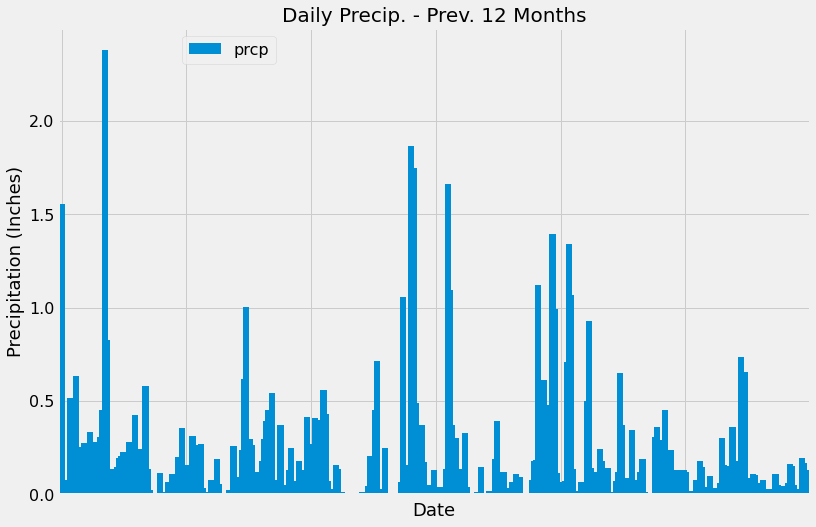

In [24]:
# convert to date
df.index = pd.to_datetime(df.index)

# Plot the precipitation for the past 12 months
ax = df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Daily Precip. - Prev. 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Output/Precipitation.png")
plt.show

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active_station = session.query(*sel).\
    filter(Measurement.station == active_stations).all()
most_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

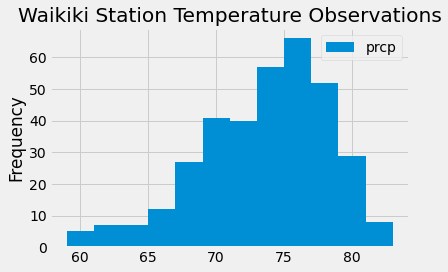

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# ma = most active (a.k.a most_active_station)
ma_prev_twelve = session.query(Measurement.date, Measurement.tobs).\
                  filter(Measurement.date >= prev_twelve).filter(Measurement.station == 'USC00519281').all()

ma_prev_twelve

# Save the query results as a Pandas DataFrame
df_2 = pd.DataFrame(ma_prev_twelve, columns=['date', 'prcp'])
df_2.head(10)

# Plot 'df_2' as histogram
df_2.plot.hist(bins=12)
plt.ylabel("Frequency")
plt.title("Waikiki Station Temperature Observations")
plt.tight_layout()
plt.show()


# Close session

In [29]:
# Close Session
session.close()